<a href="https://colab.research.google.com/github/Otobi1/Board-Game-Prediction-End-to-End/blob/master/03_Board_Game_Prediction_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Model Exploration and Selection

# - Importing the necessary libraries 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

print ("Libraries successfully imported!!!")

Libraries successfully imported!!!


In [ ]:
# Mount the drive, because the data is already on the GDrive

from google.colab import drive # for more on writing and reading files through colab https://towardsdatascience.com/reading-and-writing-files-with-google-colaboratory-f0c234683946
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Loading the dataset from the GDrive

df = pd.read_csv("/drive/My Drive/Colab Notebooks/final_game_board_dataset.csv")

In [ ]:
df.head()

,name,Year Published,Minimum Players,Maximum Players,Minimum Playtime,Maximum Playtime,Minimum Age,Language Dependence,Number of Categories,Number of Mechanics,boardgamecategory,boardgamemechanic,description,Weight,Mechanic Acting,Mechanic Action Drafting,Mechanic Action Points,Mechanic Action Queue,Mechanic Action Retrieval,Mechanic Action Timer,Mechanic Action/Event,Mechanic Advantage Token,Mechanic Alliances,Mechanic Area Majority / Influence,Mechanic Area Movement,Mechanic Area-Impulse,Mechanic Auction/Bidding,Mechanic Auction: Sealed Bid,Mechanic Auction: Turn Order Until Pass,Mechanic Automatic Resource Growth,Mechanic Betting and Bluffing,Mechanic Bias,Mechanic Bribery,Mechanic Campaign / Battle Card Driven,Mechanic Card Drafting,Mechanic Catch the Leader,Mechanic Chaining,Mechanic Chit-Pull System,Mechanic Command Cards,Mechanic Commodity Speculation,...,CategoryMemory.1,CategoryMiniatures,CategoryModern Warfare,CategoryMovies / TV / Radio theme,CategoryMurder/Mystery,CategoryMusic,CategoryMythology,CategoryNapoleonic,CategoryNautical,CategoryNegotiation.1,CategoryNovel-based,CategoryNumber,CategoryParty Game,CategoryPike and Shot,CategoryPirates,CategoryPolitical,CategoryPost-Napoleonic,CategoryPrehistoric,CategoryPrint & Play,CategoryPuzzle,CategoryRacing,CategoryReal-time,CategoryReligious,CategoryRenaissance,CategoryScience Fiction,CategorySpace Exploration,CategorySpies/Secret Agents,CategorySports,CategoryTerritory Building,CategoryTrains,CategoryTransportation,CategoryTravel,CategoryTrivia,CategoryVideo Game Theme,CategoryVietnam War,CategoryWargame,CategoryWord Game,CategoryWorld War I,CategoryWorld War II,CategoryZombies
0,Gloomhaven,2017,1,4,60,120,12,4,5,12,"Adventure, Exploration, Fantasy, Fighting, Min...","Campaign / Battle Card Driven, Cooperative Gam...",Gloomhaven is a game of Euro-inspired tactica...,3.8078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pandemic Legacy Season 1,2015,2,4,60,60,13,4,2,8,"Environmental, Medical","Action Points, Cooperative Game, Hand Manageme...",Pandemic Legacy is a co-operative campaign gam...,2.8301,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Terraforming Mars,2016,1,5,120,120,12,3,6,9,"Economic, Environmental, Industry / Manufactur...","Card Drafting, End Game Bonuses, Hand Manageme...","In the 2400s, mankind begins to terraform the ...",3.2313,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Through the Ages A New Story of Civilization,2015,2,4,120,120,14,4,3,5,"Card Game, Civilization, Economic","Action Points, Auction/Bidding, Auction: Dutch...",Through the Ages: A New Story of Civilization ...,4.3850,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Brass Birmingham,2018,2,4,60,120,14,1,3,8,"Economic, Industry / Manufacturing, Transporta...","Hand Management, Income, Loans, Market, Networ...",Brass: Birmingham is an economic strategy game...,3.9122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(19036, 307)

In [ ]:
# Converting the weight feature to categorical data for better modelling 
# Using the categories found here https://boardgamegeek.com/wiki/page/Weight

conversion_dict = {1: "light", 
                   2: "medium_light", 
                   3: "medium", 
                   4: "medium_heavy", 
                   5: "heavy"}

In [ ]:
# Rounding off the Weights

df["Weight"] = np.round(df["Weight"]) 

In [ ]:
# Mapping the coversion dictional to the Weight

df["Weight"] = df["Weight"].map(conversion_dict)

In [ ]:
# Using PolynomialFeatures to engineer more columsn to help create better models

# using polynomialfeatures to add new columns to the model hopefully helps increase accuracy. 
# it does this by multiplying each of the specified columns by every other specified column and itself. 
# the result is columns like Minimum Playtime Maximum Playtime, which is the result of the Minimum Playtime and Maximum Playtime multiplied

features = df[["Minimum Players", "Maximum Players", "Minimum Age", "Language Dependence", 
               "Minimum Playtime", "Maximum Playtime", "Number of Categories", "Number of Mechanics"]]

poly = PolynomialFeatures(degree = 2)

output_array = poly.fit_transform(features)

In [ ]:
# Adding the new featues from polynomialfeatures to the dataframe 

output_df = pd.DataFrame(output_array, columns = poly.get_feature_names(features.columns))

output_df.drop(columns = ["1", "Minimum Players", "Maximum Players", "Minimum Age", "Language Dependence", 
               "Minimum Playtime", "Maximum Playtime", "Number of Categories", "Number of Mechanics" ], inplace = True)

df = pd.concat([df, output_df], axis = 1, sort = False)
df.head()

,name,Year Published,Minimum Players,Maximum Players,Minimum Playtime,Maximum Playtime,Minimum Age,Language Dependence,Number of Categories,Number of Mechanics,boardgamecategory,boardgamemechanic,description,Weight,Mechanic Acting,Mechanic Action Drafting,Mechanic Action Points,Mechanic Action Queue,Mechanic Action Retrieval,Mechanic Action Timer,Mechanic Action/Event,Mechanic Advantage Token,Mechanic Alliances,Mechanic Area Majority / Influence,Mechanic Area Movement,Mechanic Area-Impulse,Mechanic Auction/Bidding,Mechanic Auction: Sealed Bid,Mechanic Auction: Turn Order Until Pass,Mechanic Automatic Resource Growth,Mechanic Betting and Bluffing,Mechanic Bias,Mechanic Bribery,Mechanic Campaign / Battle Card Driven,Mechanic Card Drafting,Mechanic Catch the Leader,Mechanic Chaining,Mechanic Chit-Pull System,Mechanic Command Cards,Mechanic Commodity Speculation,...,CategoryWord Game,CategoryWorld War I,CategoryWorld War II,CategoryZombies,Minimum Players^2,Minimum Players Maximum Players,Minimum Players Minimum Age,Minimum Players Language Dependence,Minimum Players Minimum Playtime,Minimum Players Maximum Playtime,Minimum Players Number of Categories,Minimum Players Number of Mechanics,Maximum Players^2,Maximum Players Minimum Age,Maximum Players Language Dependence,Maximum Players Minimum Playtime,Maximum Players Maximum Playtime,Maximum Players Number of Categories,Maximum Players Number of Mechanics,Minimum Age^2,Minimum Age Language Dependence,Minimum Age Minimum Playtime,Minimum Age Maximum Playtime,Minimum Age Number of Categories,Minimum Age Number of Mechanics,Language Dependence^2,Language Dependence Minimum Playtime,Language Dependence Maximum Playtime,Language Dependence Number of Categories,Language Dependence Number of Mechanics,Minimum Playtime^2,Minimum Playtime Maximum Playtime,Minimum Playtime Number of Categories,Minimum Playtime Number of Mechanics,Maximum Playtime^2,Maximum Playtime Number of Categories,Maximum Playtime Number of Mechanics,Number of Categories^2,Number of Categories Number of Mechanics,Number of Mechanics^2
0,Gloomhaven,2017,1,4,60,120,12,4,5,12,"Adventure, Exploration, Fantasy, Fighting, Min...","Campaign / Battle Card Driven, Cooperative Gam...",Gloomhaven is a game of Euro-inspired tactica...,medium_heavy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1.0,4.0,12.0,4.0,60.0,120.0,5.0,12.0,16.0,48.0,16.0,240.0,480.0,20.0,48.0,144.0,48.0,720.0,1440.0,60.0,144.0,16.0,240.0,480.0,20.0,48.0,3600.0,7200.0,300.0,720.0,14400.0,600.0,1440.0,25.0,60.0,144.0
1,Pandemic Legacy Season 1,2015,2,4,60,60,13,4,2,8,"Environmental, Medical","Action Points, Cooperative Game, Hand Manageme...",Pandemic Legacy is a co-operative campaign gam...,medium,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,8.0,26.0,8.0,120.0,120.0,4.0,16.0,16.0,52.0,16.0,240.0,240.0,8.0,32.0,169.0,52.0,780.0,780.0,26.0,104.0,16.0,240.0,240.0,8.0,32.0,3600.0,3600.0,120.0,480.0,3600.0,120.0,480.0,4.0,16.0,64.0
2,Terraforming Mars,2016,1,5,120,120,12,3,6,9,"Economic, Environmental, Industry / Manufactur...","Card Drafting, End Game Bonuses, Hand Manageme...","In the 2400s, mankind begins to terraform the ...",medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1.0,5.0,12.0,3.0,120.0,120.0,6.0,9.0,25.0,60.0,15.0,600.0,600.0,30.0,45.0,144.0,36.0,1440.0,1440.0,72.0,108.0,9.0,360.0,360.0,18.0,27.0,14400.0,14400.0,720.0,1080.0,14400.0,720.0,1080.0,36.0,54.0,81.0
3,Through the Ages A New Story of Civilization,2015,2,4,120,120,14,4,3,5,"Card Game, Civilization, Economic","Action Points, Auction/Bidding, Auction: Dutch...",Through the Ages: A New Story of Civilization ...,medium_heavy,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4.0,8.0,28.0,8.0,240.0,240.0,6.0,10.0,16.0,56.0,16.0,480.0,480.0,12.0,20.0,196.0,56.0,1680.0,1680.0,42.0,70.0,16.0,480.0,480.0,12.0,20.0,14400.0,14400.0,360.0,600.0,14400.0,360.0,600.0,9.0,15.0,25.0
4,Brass Birmingham,2018,2,4,60,120,14,1,3,8,"Econom

In [ ]:
X = df._get_numeric_data()
y = df["Weight"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 1919)

In [ ]:
# Modelling 

# - Base Model 

y.value_counts(normalize = True)

# A base model that predicts "medium_light" would be correct 44% of the time.

medium_light    0.441007
light           0.299170
medium          0.204245
medium_heavy    0.053215
heavy           0.002364
Name: Weight, dtype: float64

In [ ]:
# Logistic Regression Model 

pipe = Pipeline(steps = [("lr", LogisticRegression())]) # Running a pipeline of logistic regression 

params = {"lr__penalty": ["l1"], 
          "lr__C": [1], 
          "lr__solver": ["liblinear"]} # Setting parameters

gs_lr = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy", n_jobs = -2)

gs_lr.fit(X_train, y_train)
gs_lr.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
# scoring the model 

gs_lr.score(X_train, y_train) 

0.6419415843664635

In [ ]:
# cross validation scoring 

cross_val_score(gs_lr.best_estimator_, X, y, cv = 5).mean() 

0.6160941504261279

In [ ]:
# Scoring the test data

gs_lr.score(X_test, y_test)

# Inference: this model already performs better than the base model but there is room for improvement

0.623030048329481

In [ ]:
# KNN Model

# - Setting the KNN Model with a StandardScaler

pipe = Pipeline(steps = [("sc", StandardScaler()), ("knn", KNeighborsClassifier())])

# Setting Model Params 

params = {"knn__n_neighbors": [21], "knn__p": [1]}

gs_knn = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_knn.fit(X_train, y_train)
gs_knn.best_estimator_

Pipeline(memory=None,
         steps=[('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=21, p=1,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
# Scoring the model

gs_knn.score(X_train, y_train)

0.6355676962947397

In [ ]:
# Cross validation scoring 

cross_val_score(gs_knn.best_estimator_, X, y, cv = 5).mean() 

0.5847318931512715

In [ ]:
# Scoring the test data split

gs_knn.score(X_test, y_test)

#  Inference: this model performs almost as well as the Logistic Regression 

0.5986551796595924

In [ ]:
# Decision Tree Model 

# - Setting the decision tree model

pipe = Pipeline(steps = [("tree", DecisionTreeClassifier())])

# - Setting the model parameters 

params = {"tree__max_depth": [6, 8]}

gs_tree = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_tree.fit(X_train, y_train)
gs_tree.best_estimator_

Pipeline(memory=None,
         steps=[('tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=8,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [ ]:
# Scoring the model 

gs_tree.score(X_train, y_train)

0.6873993135812846

In [ ]:
# Cross validation score 

cross_val_score(gs_tree.best_estimator_, X, y, cv = 5).mean()

0.6255484837749127

In [ ]:
# Scoring the test data split

gs_tree.score(X_test, y_test)

# Inference: The decision tree performs a bit better than the logistic regression model

0.6295440218533306

In [ ]:
# Bagging Classifier Model 

# - Setting up a Bagging Classifier Model 

pipe = Pipeline(steps = [("bag", BaggingClassifier())])

# - Setting up model parameters 

params = {"bag__n_estimators": [200]}

gs_bag = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_bag.fit(X_train, y_train)
gs_bag.best_estimator_

Pipeline(memory=None,
         steps=[('bag',
                 BaggingClassifier(base_estimator=None, bootstrap=True,
                                   bootstrap_features=False, max_features=1.0,
                                   max_samples=1.0, n_estimators=200,
                                   n_jobs=None, oob_score=False,
                                   random_state=None, verbose=0,
                                   warm_start=False))],
         verbose=False)

In [ ]:
# Scoring the model 

gs_bag.score(X_train, y_train)

# Inference: looks overfit 

0.9981088463963017

In [ ]:
# Cross validation score 

cross_val_score(gs_bag.best_estimator_, X, y, cv = 5).mean()

0.6294363214158792

In [ ]:
# Scoring the test data

gs_bag.score(X_test, y_test) 

# Inference: although with the best performance on the test data so far, the train set seems overfit 

0.6432023534355957

In [ ]:
# Random Forest Model 

# - Setting up the model

pipe = Pipeline(steps = [("forest", RandomForestClassifier())])

# Setting the model parameters 

params = {"forest__n_estimators": [150], "forest__max_depth": [15]}

gs_forest = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_forest.fit(X_train, y_train)

gs_forest.best_estimator_

Pipeline(memory=None,
         steps=[('forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=150, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
# Scoring the model 

gs_forest.score(X_train, y_train)

0.8581634797226309

In [ ]:
# Cross validation scoring 
cross_val_score(gs_forest.best_estimator_, X, y, cv = 5).mean()

0.6434096136484538

In [ ]:
# Scoring the test data split

gs_forest.score(X_test, y_test)

# Inference: Random Forest as good as the Bagging Classifier, lets continue up the bias-variance trade off

0.6507669678503888

In [ ]:
# Extra Trees Model 

# - Setting up the model

pipe = Pipeline(steps = [("extra", ExtraTreesClassifier())])

# Setting up the model parameters 

params = {"extra__n_estimators": [600], "extra__max_depth": [None]}

gs_extra = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_extra.fit(X_train, y_train)
gs_extra.best_estimator_

Pipeline(memory=None,
         steps=[('extra',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=600, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
# Scoring the model 

gs_extra.score(X_train, y_train)

0.9981088463963017

In [ ]:
# Cross validation score 

cross_val_score(gs_extra.best_estimator_, X, y, cv = 5).mean()

0.6391015113689289

In [ ]:
# Scoring the test data split

gs_extra.score(X_test, y_test)

# Inference: About as strong as the Bagging Classifier, lets try the boosting models next

0.6432023534355957

In [ ]:
# AdaBoost Model 

# - Setting up the model 

pipe = Pipeline(steps = [("ada", AdaBoostClassifier())])

# - Setting the model parameters 

params = {"ada__n_estimators": [10]}

gs_ada = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_ada.fit(X_train, y_train)
gs_ada.best_estimator_

Pipeline(memory=None,
         steps=[('ada',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=10,
                                    random_state=None))],
         verbose=False)

In [ ]:
# Scoring the model 

gs_ada.score(X_train, y_train)

0.5311339917349583

In [ ]:
# Cross validation scoring 

cross_val_score(gs_ada.best_estimator_, X, y, cv = 5).mean()

0.5370845087443961

In [ ]:
# Scoring the test data split 

gs_ada.score(X_test, y_test)

# Inference: did not perform as well, even lower than KNN

0.5242698045807943

In [ ]:
# Gradient Boost Model 

# - Setting up the model 

pipe = Pipeline(steps = [("grad", GradientBoostingClassifier())])

# - Setting up the model parameters 

params = {"grad__n_estimators": [300], "grad__max_depth": [3]}

gs_grad = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_grad.fit(X_train, y_train)
gs_grad.best_estimator_

Pipeline(memory=None,
         steps=[('grad',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=300,
                                            n_iter_no_change=None,
                                            presort='deprecated',
                                            random_sta

In [ ]:
# Scoring the model

gs_grad.score(X_train, y_train)

0.7533795615325348

In [ ]:
# Cross validation scoring 

cross_val_score(gs_grad.best_estimator_, X, y, cv = 5).mean()

0.6478746305456777

In [ ]:
# Scoring the test data split

gs_grad.score(X_test, y_test)

# Inference: Best model so far, but lets try SVM

0.6583315822651817

In [ ]:
# SVC Model 

# - Setting up the model 

pipe = Pipeline(steps = [("svc", SVC())])

# - Setting the model parameters 

params = {"svc__C": [3]}

gs_svc = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_svc.fit(X_train, y_train)

gs_svc.best_estimator_

Pipeline(memory=None,
         steps=[('svc',
                 SVC(C=3, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
# Scoring the model 

gs_svc.score(X_train, y_train)

0.4423898578132661

In [ ]:
# Cross validation scoring 

cross_val_score(gs_svc.best_estimator_, X, y, cv = 5).mean()

0.4418995967181199

In [ ]:
# Scoring the test data split 

gs_svc.score(X_test, y_test)

# Inference: the added dimensionality did not help much, this is the poorest performing model yet.

0.4416894305526371

In [ ]:
# Voting Classifier Model

# - Setting up the model 

knn_pipe = Pipeline([("ss", StandardScaler()), ("knn", KNeighborsClassifier())])

# = Setting up the Voting Classifier Model  with multiple models inside

vote = VotingClassifier([("rand", RandomForestClassifier()), 
                         ("grad", GradientBoostingClassifier()), 
                         ("lr", LogisticRegression()), 
                         ("tree", DecisionTreeClassifier()), 
                         ("bag", BaggingClassifier()), 
                         ("ada", AdaBoostClassifier()), 
                         ("extra", ExtraTreesClassifier()), 
                         ("knn_pipe", knn_pipe)], voting = "soft")

# Setting up the model parameters for each model in the voting classifier 

vote_params = {"rand__n_estimators": [150], 
               "rand__max_depth": [15], 
               "grad__n_estimators": [300], 
               "tree__max_depth": [8], 
               "bag__n_estimators": [200], 
               "ada__n_estimators": [10], 
               "extra__n_estimators": [600], 
               "knn_pipe__knn__n_neighbors": [21],
               "lr__penalty": ["l1"], 
               "lr__C": [1], 
               "lr__solver": ["liblinear"]}

gs_vc = GridSearchCV(vote, param_grid = vote_params, cv = 5, scoring = "accuracy")

gs_vc.fit(X_train, y_train)

gs_vc.best_estimator_

VotingClassifier(estimators=[('rand',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=15,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
        

In [ ]:
# Scoring the model 

gs_vc.score(X_train, y_train)

0.9127968060516916

In [ ]:
# Cross validation scoring 

cross_val_score(gs_vc.best_estimator_, X, y, cv = 5).mean()

0.6529180407387541

In [ ]:
# Scoring the test data split

gs_vc.score(X_test, y_test)


# Model Selection
# inference: the voting classifier performed best of all the models tested but they are hard to evaluate because they are ensemble models. 
# So while we will use the voting classifier to predict the complexity of the game, we'll evaluate the Logistic Regression model as it is only a few points of the voting classifier

0.6631645303635217

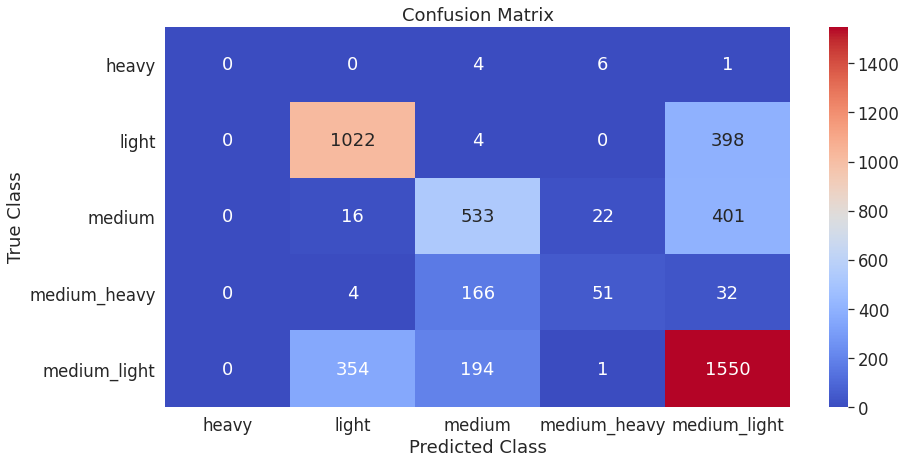

In [ ]:
# Model Evaluation 

# - First the Voting Classifier Model

vc_preds = gs_vc.best_estimator_.predict(X_test) # getting predictiosn from the voting classifier model 

def pretty_confusion_matrix(y_true, y_pred):
  """ Creates a confusion matrix and puts it into a prettier looking chart."""

  # Handling the data
  cm = confusion_matrix(y_true, y_pred)
  labels = y_true.unique()
  labels.sort()

  # Plotting 
  sns.set(font_scale = 1.5)
  plt.figure(figsize = (14, 7))

  chart = sns.heatmap(cm, annot = True, fmt = "g", cmap = "coolwarm", xticklabels = labels, yticklabels = labels)
  chart.set_yticklabels(chart.get_yticklabels(), rotation = 0)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")

pretty_confusion_matrix(y_test, vc_preds) # https://github.com/q-downgrade/dsi-capstone/blob/master/code/2-modeling-notebook.ipynb for more description on the implications and an explainer 


In [ ]:
print(f'Light positive rate       : {1022/(1022+4+398+0+0)}')
print(f'Medium light positive     : {1550/(1550+1+194+354+0)}')
print(f'Medium  positive          : {533/(533+16+22+401+0)}')
print(f'Medium heavy positive     : {51/(54+4+166+0+32)}')
print(f'Heavy positive            : {0}')

Light positive rate       : 0.7176966292134831
Medium light positive     : 0.7384468794664126
Medium  positive          : 0.5483539094650206
Medium heavy positive     : 0.19921875
Heavy positive            : 0


In [ ]:
# - Now, lets look at the Coefficients of the Logistic Regression 

# getting the list of features 
keys = list(X_test.keys()) 

# getting the classes from the Logistic Regression
classes = gs_lr.best_estimator_.steps[0][1].classes_ 

# getting the coeffs from the model 
coefs = gs_lr.best_estimator_.steps[0][1].coef_

# setting up a dataframe with the features in one column 
coefs_df = pd.DataFrame(keys, columns = ["features"])

# filling out the dataframe with the coefficients of each feature, separate class
for i, cl in enumerate(classes):
  coefs_df[cl] = coefs[i]

In [ ]:
# lets plot the top and bottom coefficients for the complexity category specified

def coef_plot(category):
  
  # getting the top 15 coefficients
  coefs_1 = coefs_df.sort_values(by = category, ascending = False).head(15)

  # getting the bottom 15 coefficients 
  coefs_2 = coefs_df.sort_values(by = category, ascending = False).tail(15)

  # merging into one 
  coefs = pd.concat([coefs_1, coefs_2], axis = 0)

  # plotting importance
  # - plotting the coefficients 
  plt.figure(figsize = (10, 15)) # plotting the coefficients
  plt.title(f"Feature Coefficients for {category.title()} Complexitiy", fontsize = 15)
  sns.set_style("darkgrid")
  sns.barplot(data = coefs, 
              x = category, 
              y = "features", 
              orient = "h",
              palette = "mako_r")
  plt.xlabel("coefficient", fontsize = 12)
  plt.ylabel("feature", fontsize = 12)
  plt.tick_params(labelsize = 12)

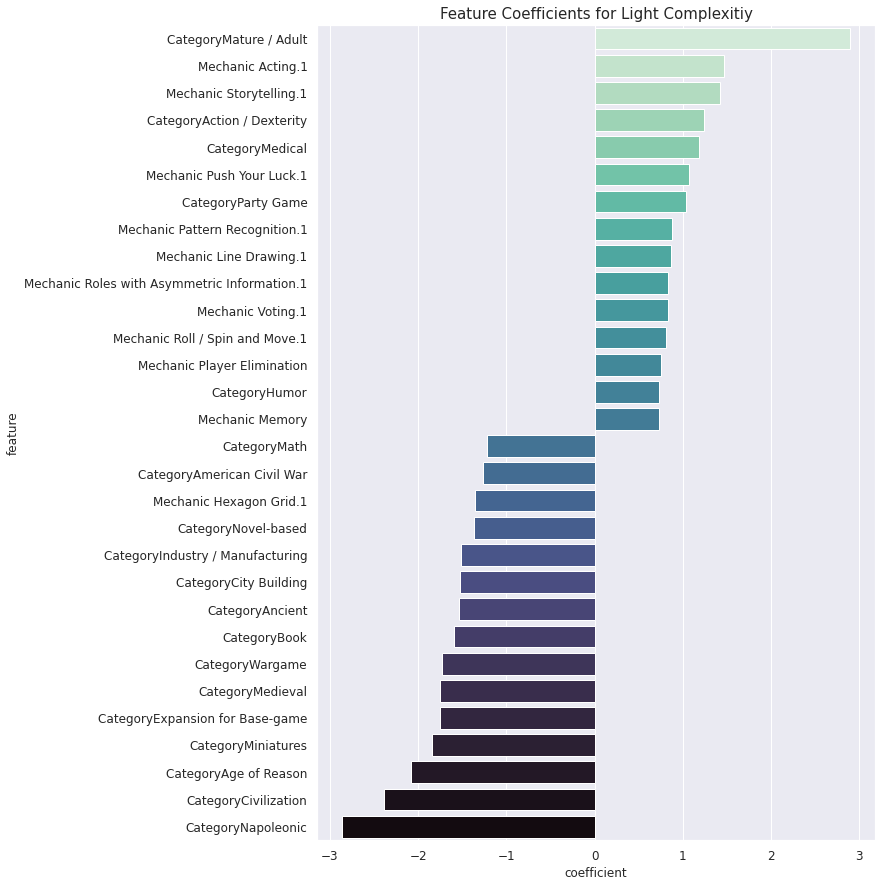

In [ ]:
coef_plot("light") # for the "light" complexity

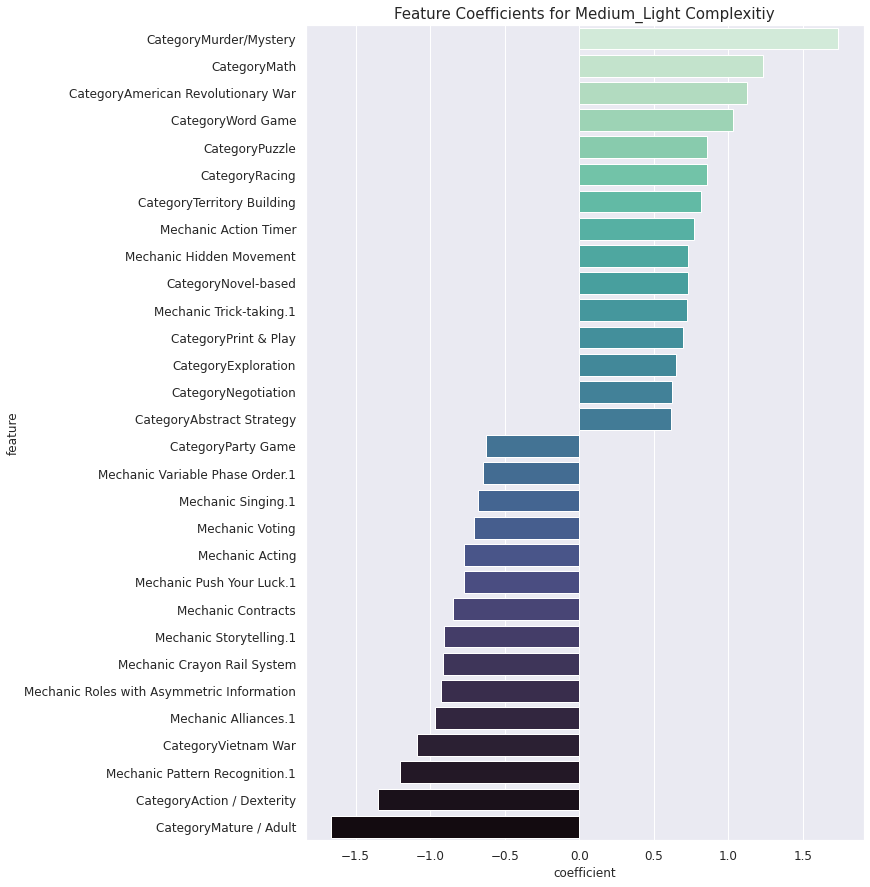

In [ ]:
coef_plot("medium_light") # for the "medium light complexity"

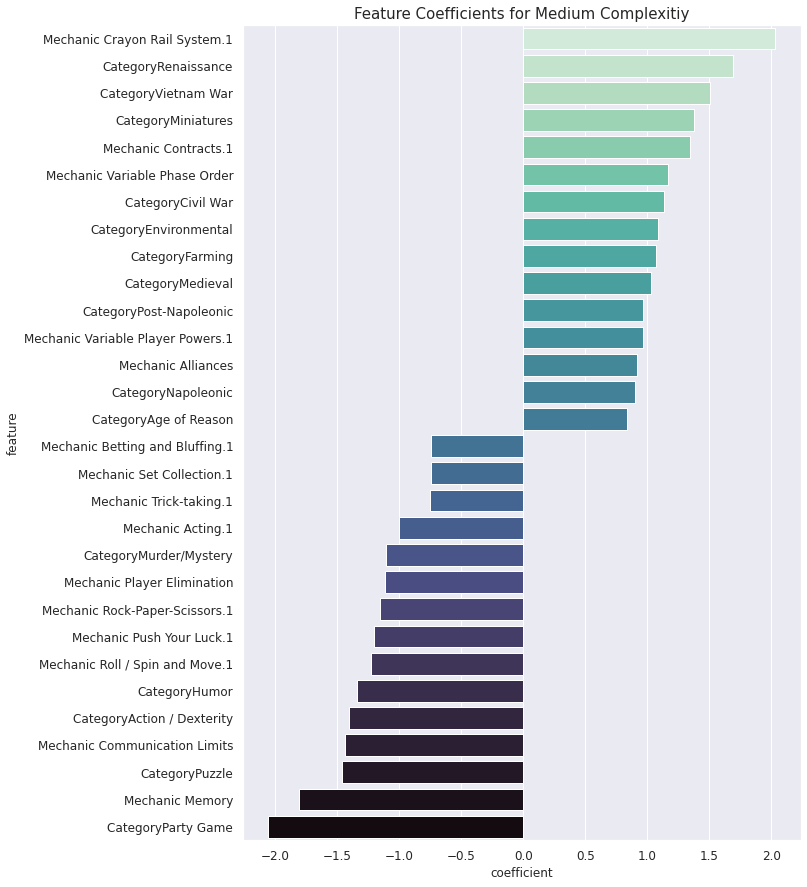

In [ ]:
coef_plot("medium") # for the medium complexity 

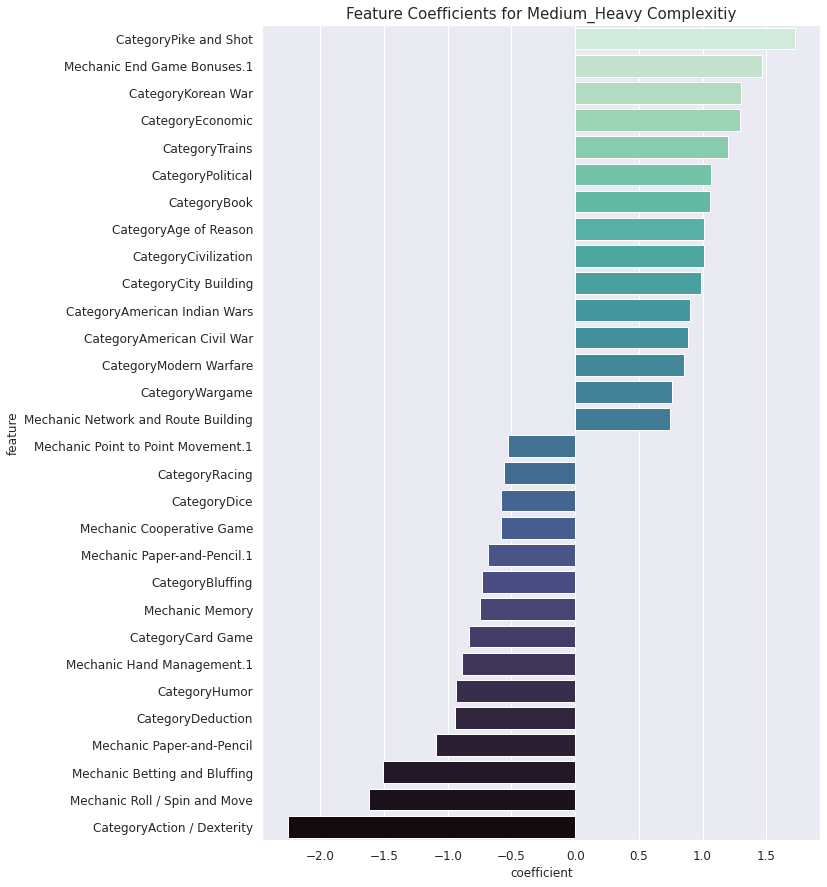

In [ ]:
coef_plot("medium_heavy") # for the medium heavy complexity

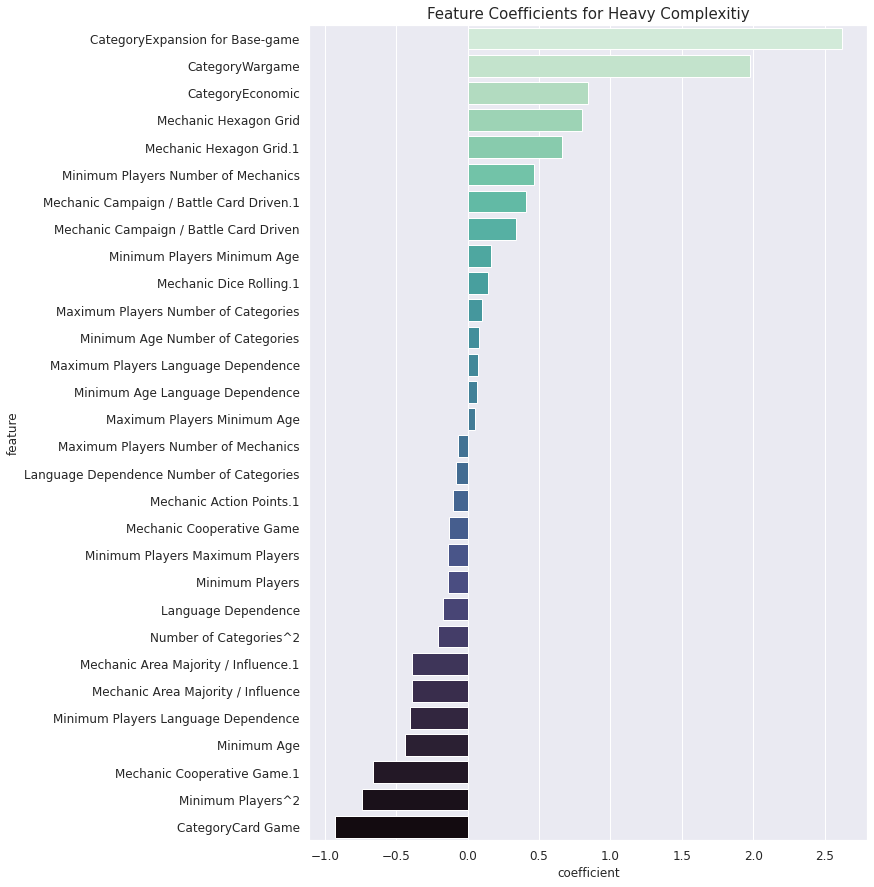

In [ ]:
coef_plot("heavy") # for the heavy complexity